In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

# absolute path to ST modules
module_path = r'C:\Users\Jose Alvarez\Documents\Projects\CounterfactualSituationTesting\src'
# module_path = os.path.abspath(os.path.join('../src')) # or the path to your source code
sys.path.insert(0, module_path)
# local files
from src.situation_testing.situation_testing import SituationTesting

In [2]:
# load datasets
data_path = os.getcwd() + '\\' + 'data' + '\\'
# factual dataset
org_df    = pd.read_csv(data_path + 'LoanApplication_v2.csv', sep='|', )
# counterfactual dataset
org_cf_df = pd.read_csv(data_path + 'counterfactuals\\cf_LoanApplication_v2.csv', sep='|', )

### Paremeters for test
We can run standard ST, counterfactual ST with/without the search centers, and counterfactual fairness. Notice that CF is included within cfST when incuding the search centers.

In [4]:
# attribute-specific params
feat_trgt = 'LoanApproval'
feat_trgt_vals = {'positive': 1, 'negative': -1}
# list of relevant features
feat_rlvt = ['AnnualSalary', 'AccountBalance']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 0, 'protected': 1}

# st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

In [5]:
res_df = org_df[['Gender', 'LoanApproval']].copy()
res_df['cf_LoanApproval'] = org_cf_df['LoanApproval'].copy()
res_df.head(5)

,Gender,LoanApproval,cf_LoanApproval
0,1,-1.0,-1.0
1,0,1.0,1.0
2,0,-1.0,-1.0
3,0,-1.0,-1.0
4,1,1.0,1.0


From one of the CLeaR reviewers: what is your Oracle?
I guess, in this world, it would be a world freed from systematic bias, meaning counterfactual fairness captures this discrepancy between worlds, no?

The world where $X_1$ and $X_2$ are born without $A$'s influence is a counterfactually fair world by definition from Kusner et al.!!!

In [6]:
print(res_df[(res_df['Gender'] == 1) & (res_df['LoanApproval'] == 1)].shape[0])
# vs
print(res_df[(res_df['Gender'] == 1) & (res_df['cf_LoanApproval'] == 1)].shape[0]) #ground truth (if you will)

674
1050


### Standard ST (stST)

In [7]:
test_df = org_df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['ST'] = st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                      sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                      k=n, alpha=alpha, tau=tau)

standardizing factual dataset


In [8]:
# get all neighborhoods for ST
stST_knn = st.res_dict_df_neighbors

In [9]:
# get the distances 
stST_dis = st.res_dict_dist_to_neighbors

### Counterfactual ST (cfST) - without centers

In [10]:
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfST'] = cf_st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                           sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                           include_centers=False,
                           k=n, alpha=alpha, tau=tau)

standardizing factual dataset
standardizing counterfactual dataset


In [11]:
# get all neighnorhoods for cfST
cfST_knn = cf_st.res_dict_df_neighbors

In [12]:
# get the distances
cfST_dis = cf_st.res_dict_dist_to_neighbors

### stST vs cfST:

- look at the cfST without centers (to be able to compare them)
- look at the c's that are shared between both methods: look at the distribution of each's ctr and tst
    - also look at the factual vs counterfactuals: average distance among this set
- look at the c's that are NOT shared between both methods and do the same

In [13]:
# sets of interest:

# c in stST and in stCF
set1 = res_df[(res_df['ST'] > tau) & (res_df['cfST'] > tau)].index.to_list()
print(len(set1))

# c not in stST but in stCF
set2 = [c for c in res_df[(res_df['cfST'] > tau)].index.to_list() if c not in set1]
print(len(set2))

55
233


[2285, 1306, 3223, 3267, 2446]


<AxesSubplot:xlabel='ID', ylabel='AccountBalance'>

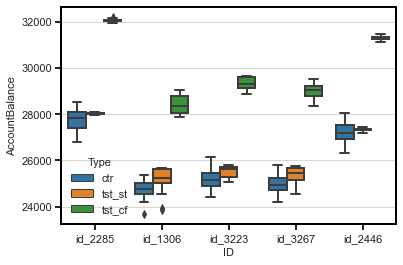

In [14]:
# let's look at those c's that appear both in stST and cfST
test_n = 5

test_c = random.sample(set1, test_n)
# test_c = random.sample(set2, test_n)

print(test_c)

var = ['AnnualSalary', 'AccountBalance']
temp_df_list = []

for c in test_c:
    
#     print('===== ===== =====')
    
#     print(stST_knn[c]['ctr_idx'])
    temp_ctr = org_df.iloc[stST_knn[c]['ctr_idx'], :][var].copy()
    temp_ctr['ID'] = 'id_' + str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr
    
#     print(stST_knn[c]['tst_idx'])
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_st['ID'] = 'id_' + str(c)
    temp_tst_st['Type'] = 'tst_st'
    temp_df_list.append(temp_tst_st)
    del temp_tst_st
    
#     print(cfST_knn[c]['tst_idx'])
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_cf['ID'] = 'id_' + str(c)
    temp_tst_cf['Type'] = 'tst_cf'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf
    
    

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

# box_plot_data
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['AccountBalance'],
            hue = box_plot_data['Type'])

# todo: save var x set combination 

In [19]:
# Get summary stats
nsf = 3
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance']
var.append('LoanApproval')

for c in set1:
    
    temp_df = {}
    temp_ctr    = org_df.iloc[stST_knn[c]['ctr_idx'], :][var]
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var]
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var]
    
    temp_df['id'] = c
    
    temp_df['neg_y_ctr']    = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_st'] = temp_tst_st[temp_tst_st['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_cf'] = temp_tst_cf[temp_tst_cf['LoanApproval'] == -1].shape[0]
    
    temp_df['avg_d_ctr']    = round(sum(stST_dis[c]['ctr_idx']) / len(stST_dis[c]['ctr_idx']), nsf)
    temp_df['avg_d_tst_st'] = round(sum(stST_dis[c]['tst_idx']) / len(stST_dis[c]['tst_idx']), nsf)
    temp_df['avg_d_tst_cf'] = round(sum(cfST_dis[c]['tst_idx']) / len(cfST_dis[c]['tst_idx']), nsf)
    
    
    for v in var:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        
        temp_df['avg_tst_st_' + v] = round(temp_tst_st.mean()[v], nsf)
        temp_df['std_tst_st_' + v] = round(temp_tst_st.std()[v], nsf)
        
        temp_df['avg_tst_cf_' + v] = round(temp_tst_cf.mean()[v], nsf)
        temp_df['std_tst_cf_' + v] = round(temp_tst_cf.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set1_summary_stats = pd.DataFrame(list_temp_df)

set1_summary_stats.head(5)

,id,neg_y_ctr,neg_y_tst_st,neg_y_tst_cf,avg_d_ctr,avg_d_tst_st,avg_d_tst_cf,avg_ctr_AnnualSalary,std_ctr_AnnualSalary,avg_tst_st_AnnualSalary,...,avg_tst_st_AccountBalance,std_tst_st_AccountBalance,avg_tst_cf_AccountBalance,std_tst_cf_AccountBalance,avg_ctr_LoanApproval,std_ctr_LoanApproval,avg_tst_st_LoanApproval,std_tst_st_LoanApproval,avg_tst_cf_LoanApproval,std_tst_cf_LoanApproval
0,5,1,0,0,0.045,0.030,0.034,101866.667,2635.382,100000.000,...,25924.084,315.756,29959.044,211.075,0.867,0.516,1.0,0.0,1.0,0.0
1,147,8,0,0,0.023,0.037,0.034,86733.333,1222.799,90000.000,...,27822.319,54.949,31842.261,104.767,-0.067,1.033,1.0,0.0,1.0,0.0
2,181,3,0,0,0.020,0.044,0.033,96000.000,1085.620,100000.000,...,26496.011,236.243,30284.475,159.957,0.600,0.828,1.0,0.0,1.0,0.0
3,264,7,0,0,0.030,0.046,0.044,85900.000,1784.857,90000.000,...,28101.909,34.608,32115.335,85.740,0.067,1.033,1.0,0.0,1.0,0.0
4,420,1,0,0,0.060,0.056,0.058,86800.000,3161.148,89333.333,...,30108.420,188.493,34093.135,389.195,0.867,0.516,1.0,0.0,1.0,0.0


In [20]:
# Get summary stats
nsf = 1
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance']
var.append('LoanApproval')

for c in set2:
    
    temp_df = {}
    temp_ctr    = org_df.iloc[stST_knn[c]['ctr_idx'], :][var]
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var]
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var]
    
    temp_df['id'] = c
    
    temp_df['neg_y_ctr']    = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_st'] = temp_tst_st[temp_tst_st['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_cf'] = temp_tst_cf[temp_tst_cf['LoanApproval'] == -1].shape[0]
    
    temp_df['avg_d_ctr']    = round(sum(stST_dis[c]['ctr_idx']) / len(stST_dis[c]['ctr_idx']), nsf)
    temp_df['avg_d_tst_st'] = round(sum(stST_dis[c]['tst_idx']) / len(stST_dis[c]['tst_idx']), nsf)
    temp_df['avg_d_tst_cf'] = round(sum(cfST_dis[c]['tst_idx']) / len(cfST_dis[c]['tst_idx']), nsf)
    
    for v in var:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        
        temp_df['avg_tst_st_' + v] = round(temp_tst_st.mean()[v], nsf)
        temp_df['std_tst_st_' + v] = round(temp_tst_st.std()[v], nsf)
        
        temp_df['avg_tst_cf_' + v] = round(temp_tst_cf.mean()[v], nsf)
        temp_df['std_tst_cf_' + v] = round(temp_tst_cf.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set2_summary_stats = pd.DataFrame(list_temp_df)
set2_summary_stats.head(5)

,id,neg_y_ctr,neg_y_tst_st,neg_y_tst_cf,avg_d_ctr,avg_d_tst_st,avg_d_tst_cf,avg_ctr_AnnualSalary,std_ctr_AnnualSalary,avg_tst_st_AnnualSalary,...,avg_tst_st_AccountBalance,std_tst_st_AccountBalance,avg_tst_cf_AccountBalance,std_tst_cf_AccountBalance,avg_ctr_LoanApproval,std_ctr_LoanApproval,avg_tst_st_LoanApproval,std_tst_st_LoanApproval,avg_tst_cf_LoanApproval,std_tst_cf_LoanApproval
0,9,15,15,14,0.0,0.0,0.1,83500.0,2203.9,80000.0,...,21309.1,119.3,25060.9,92.9,-1.0,0.0,-1.0,0.0,-0.9,0.5
1,44,15,15,0,0.0,0.0,0.0,88800.0,1485.6,90000.0,...,26097.8,86.9,30049.6,71.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,50,15,15,0,0.0,0.0,0.0,89833.3,1291.0,90000.0,...,23318.6,211.8,27131.0,125.1,-1.0,0.0,-1.0,0.0,1.0,0.0
3,55,12,15,0,0.0,0.0,0.0,93500.0,886.4,90000.0,...,25726.0,60.7,29655.6,50.1,-0.6,0.8,-1.0,0.0,1.0,0.0
4,89,15,15,0,0.1,0.1,0.1,77300.0,2094.2,79333.3,...,27111.5,104.8,31205.6,514.6,-1.0,0.0,-1.0,0.0,1.0,0.0


In [21]:
set1_summary_stats.mean()

id                             2832.509091
neg_y_ctr                         8.818182
neg_y_tst_st                      2.218182
neg_y_tst_cf                      0.000000
avg_d_ctr                         0.030636
avg_d_tst_st                      0.039818
avg_d_tst_cf                      0.032164
avg_ctr_AnnualSalary          94372.121273
std_ctr_AnnualSalary           1646.290909
avg_tst_st_AnnualSalary       96181.818182
std_tst_st_AnnualSalary         611.567818
avg_tst_cf_AnnualSalary      106569.696964
std_tst_cf_AnnualSalary         286.344545
avg_ctr_AccountBalance        26092.927218
std_ctr_AccountBalance          558.299127
avg_tst_st_AccountBalance     26347.455273
std_tst_st_AccountBalance       352.780873
avg_tst_cf_AccountBalance     30141.280873
std_tst_cf_AccountBalance       273.448636
avg_ctr_LoanApproval             -0.175709
std_ctr_LoanApproval              0.722527
avg_tst_st_LoanApproval           0.704273
std_tst_st_LoanApproval           0.387418
avg_tst_cf_

In [22]:
set2_summary_stats.mean()

id                            2456.381974
neg_y_ctr                       13.742489
neg_y_tst_st                    14.785408
neg_y_tst_cf                     0.781116
avg_d_ctr                        0.005150
avg_d_tst_st                     0.022747
avg_d_tst_cf                     0.014163
avg_ctr_AnnualSalary         86332.474678
std_ctr_AnnualSalary          1524.329614
avg_tst_st_AnnualSalary      85911.303004
std_tst_st_AnnualSalary        906.112876
avg_tst_cf_AnnualSalary      96898.426180
std_tst_cf_AnnualSalary        391.491416
avg_ctr_AccountBalance       24734.113305
std_ctr_AccountBalance         482.149785
avg_tst_st_AccountBalance    24790.047210
std_tst_st_AccountBalance      152.076395
avg_tst_cf_AccountBalance    28677.113305
std_tst_cf_AccountBalance      171.609442
avg_ctr_LoanApproval            -0.832618
std_ctr_LoanApproval             0.160086
avg_tst_st_LoanApproval         -0.972103
std_tst_st_LoanApproval          0.038197
avg_tst_cf_LoanApproval          0

### Summary of stST vs cfST

Using the boxplots, even for the c's that share standard and counterfactual ST, we see the notions of fairness fiven the difference. While the test group under stST is more align with the control group, the test group under cfST is clearly different from it yet we're comparing these two groups to detect discrimination.

- Add both plots to show that this is a pattern.
- Add the summary stats... what seems to be the issue is that, on average, set 1 has closer groups. You can see this in the boxplots of random samples.
- This reinforces our discrimination approach - to be added to Experiments and Appendix.

- When looking at the number of rejections, we see that cfST captures more (male) test groups that have no rejections: the discrimination claim becomes clearer here!

- When looking at the distance, we don't see a reduction in tighness: it just seems that what differs is the the test center but the neighboors are still close by: doesn't add much tbh.

Here, clearly, we can see the difference between using the idealized comparison vs the fairness given the difference. This explains the numbers in Table 1. This is key wrt to discrimination analysis.

### cfST vs CF

Now we move into causal fairness... things to highlight:

- Based on Table 1, it seems that CF already incorporates "fairness given the difference", meaning that the criticism that came after the method's apperance are unfounded: Hu and Kohler-Hausmann are wrong there. Our conclusion is that counterfactuals, as conceived by Pearl, are the right way forward for discrimination analysis that are fairer.

- Now, we wonder/ask weather CF is enough for detecting discrimination in-itself? Under ST, at least algorithnically, we don't include the centers. We have added to cfST the option to include or not the centers, which are by definition the CF literal comparisson. We can, in that sense, explore the application of CF to discrimination analysis.

- We can think of several reasons why CF and causal fairness overall is suitable for discrimination analysis: 1) Discrimination is conceived as a causal query: does the protected attribute "cause" directly/indirectly the outcome in question? 2) Discrimination analysis relies on expert knowledge (think of calling a hiring officer as a witness for a hiring discrimnation case) and we see the causal DAG as a nice tools of communication between non-technical and technical experts: the DAG can serve as a bridge to easily translate expert knowledge into a structure for modelling. 3) In particular, CF, comes natural in discrimination cases: it literally seems to operationalize the KHC.

Note: be clear about the synthetic data. We create an ideal world (consider it the counterfactual) and then modify it to be systemtically unfair to women. Hence, what we observe is the factual but then the counterfactual shows the ideal world. It both shows how KHC is relevant (highlight the limits of ideal comparissons) and how CF implkictly addresses this.

- We can, however, think about other reasons that makes CF unsuitable as is for discrimination analasys. 
    - 1) Our understanding of the legal literature is that the literal comparisson is not enough. Granted, CF was not an option when the law was written and the method has not been used yet. But CF is limited to the single instance and doesn't account for the uncertainty of decision making process in question. This uncertainty is often approximated by "repeating the process", i.e. treated as an inferential question. Discrimination tools approximate this (as repetition is not an option) by looking at similar instances and seeing what happens. We've shown the limitations of this approach by looking at the ideal comparison, but then cfST address the need to neighborhoods based on CF. We don't see cfST as a substitute, instead **we see it as an extension of it for discrimination analysis**.
    - 2) For example, suppose we have c and its $c^{scf}$ near the decision border, such that both c and $c^{scf}$ are $\hat{Y}=0$. Then  for c, the decision maker is counterfactually fair, but what happens when we look at the neighborhoods for both control and test groups? $c$ si surrounded by rejected (female) instances, but if $c^{scf}$ is at the border then its (test) neighborhood would have rejected and accpeted instances - in a way, mimicking this idea of repeating the process over and over for $c$. Hence, if the factual, female version is always rejected while its counterfactual, male version is sometimes rejected (here, we are implictly doing fairness given the difference) then are we actually fair for $c$? Again, discrimination is legally grounded and it requires evidence of a pattern: individual claim alone may not be enough (as we understand it). Again, that's why we see cfST as a discrimination analysis tool extension of CF.
    - 3) Another limitation is that CF is only limited to the individual comparisson: factual vs counterfactual. Instead by looking at the proportions we can conceive unfari instances differently. In particular, we can look at $\tau$-discrimination, where recall that $\tau$ is the deviation in the proportions from the expected behaviour. 
    
    If we define discrimination in terms of CF, essentially $\tau$ has to be 0 for us to consider these instances as discriminatory. This is because CF requieres that the factual and counterfactuals are identical or not. Now, under cfST, we can play with this... this is also the case in court: we could have some level of "mercy" toward the decision maker and $\tau > 0$ to reflect this. So cfST is more robust because of the proportions, not to mention that the proportions allow us to have inferential properties! (4) CF doesn't have inferential properties, which might be an issue for the policy makers (maybe 1 and 4 are the same?).
    
    That said, if all CF instances fall under cfST, then we show that we cover the starting point but can enhance it by looking at the neighborhoods. We extend it by looking at other suspucious instances (still under $\tau=0$).

### Counterfactual ST (cfST) - with centers

In [23]:
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

# include the centers
cf_st_with = SituationTesting()
cf_st_with.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfSTwith'] = cf_st_with.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                                    sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                                    include_centers=True,
                                    k=n, alpha=alpha, tau=tau)

standardizing factual dataset
standardizing counterfactual dataset


In [24]:
# get all neighnorhoods for cfST
cfST_knn_with = cf_st_with.res_dict_df_neighbors

In [25]:
res_df['CF'] = cf_st_with.res_counterfactual_unfairness

In [26]:
res_df.head(5)

,Gender,LoanApproval,cf_LoanApproval,ST,cfST,cfSTwith,CF
0,1,-1.0,-1.0,0.0,0.0,0.0,False
1,0,1.0,1.0,0.0,0.0,0.0,0
2,0,-1.0,-1.0,0.0,0.0,0.0,0
3,0,-1.0,-1.0,0.0,0.0,0.0,0
4,1,1.0,1.0,0.0,0.0,0.0,False


In [27]:
# number of counterfactuals: under a CF defitinion of discrimination
res_df[res_df['CF'] == True].shape

(376, 7)

In [28]:
# sets of interest:

# total disc cases under cfST
print(len(res_df[(res_df['cfSTwith'] > tau)].index.to_list()))

# c in cfST and in CF
set3 = res_df[(res_df['cfSTwith'] > tau) & (res_df['CF'] == True)].index.to_list()
print(len(set3))

# c not in CF but in cfST
set4 = [c for c in res_df[(res_df['cfSTwith'] > tau)].index.to_list() if c not in set3]
print(len(set4))

420
376
44


[1245, 4747, 2023, 121, 3065]


<AxesSubplot:xlabel='ID', ylabel='AccountBalance'>

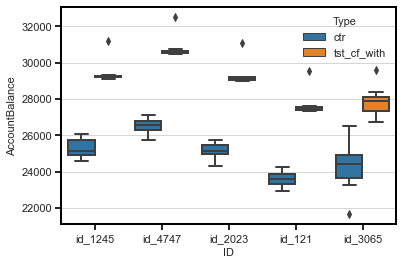

In [29]:
test_n = 5

test_c = random.sample(set3, test_n)
# test_c = random.sample(set2, test_n)
print(test_c)

var = ['AnnualSalary', 'AccountBalance']
temp_df_list = []

for c in test_c:
    
#     print('===== ===== =====')
    
#     print(stST_knn[c]['ctr_idx'])
    temp_ctr = org_df.iloc[cfST_knn_with[c]['ctr_idx'], :][var].copy()
    temp_ctr = temp_ctr.append(org_df.iloc[c][var])    
    temp_ctr['ID'] = 'id_' + str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr
        
#     print(cfST_knn[c]['tst_idx'])
    temp_tst_cf = org_cf_df.iloc[cfST_knn_with[c]['tst_idx'], :][var].copy()
    temp_tst_cf = temp_tst_cf.append(org_cf_df.iloc[c][var]) 
    temp_tst_cf['ID'] = 'id_' + str(c)
    temp_tst_cf['Type'] = 'tst_cf_with'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf
    
    

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

# box_plot_data
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['AccountBalance'],
            hue = box_plot_data['Type'])

[4072, 4631, 4484, 484, 4714]


<AxesSubplot:xlabel='ID', ylabel='AccountBalance'>

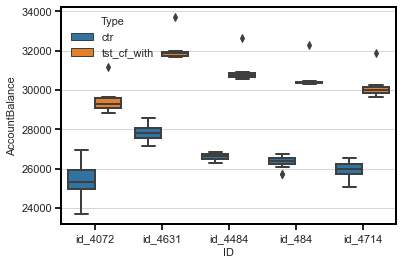

In [30]:
test_n = 5

test_c = random.sample(set4, test_n)
# test_c = random.sample(set2, test_n)
print(test_c)

var = ['AnnualSalary', 'AccountBalance']
temp_df_list = []

for c in test_c:
    
#     print('===== ===== =====')
    
#     print(stST_knn[c]['ctr_idx'])
    temp_ctr = org_df.iloc[cfST_knn_with[c]['ctr_idx'], :][var].copy()
    temp_ctr = temp_ctr.append(org_df.iloc[c][var])
    temp_ctr['ID'] = 'id_' + str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr
        
#     print(cfST_knn[c]['tst_idx'])
    temp_tst_cf = org_cf_df.iloc[cfST_knn_with[c]['tst_idx'], :][var].copy()
    temp_tst_cf = temp_tst_cf.append(org_cf_df.iloc[c][var]) 
    temp_tst_cf['ID'] = 'id_' + str(c)
    temp_tst_cf['Type'] = 'tst_cf_with'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

# box_plot_data
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['AccountBalance'],
            hue = box_plot_data['Type'])

In [31]:
# Get summary stats
nsf = 3
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance']
var.append('LoanApproval')

for c in set3:
    
    temp_df = {}
    temp_ctr         = org_df.iloc[cfST_knn_with[c]['ctr_idx'], :][var].copy()
    temp_ctr = temp_ctr.append(org_df.iloc[c][var])
    temp_tst_cf_with = org_cf_df.iloc[cfST_knn_with[c]['tst_idx'], :][var].copy()
    temp_tst_cf_with = temp_tst_cf_with.append(org_cf_df.iloc[c][var]) 
    
    temp_df['id'] = c
    temp_df['neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval']==-1].shape[0]
    temp_df['neg_y_tst_cfw'] = temp_tst_cf_with[temp_tst_cf_with['LoanApproval']==-1].shape[0] 
    
    for v in var:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
                
        temp_df['avg_tst_cfw_' + v] = round(temp_tst_cf_with.mean()[v], nsf)
        temp_df['std_tst_cfw_' + v] = round(temp_tst_cf_with.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set3_summary_stats = pd.DataFrame(list_temp_df)

set3_summary_stats.head(5)

,id,neg_y_ctr,neg_y_tst_cfw,avg_ctr_AnnualSalary,std_ctr_AnnualSalary,avg_tst_cfw_AnnualSalary,std_tst_cfw_AnnualSalary,avg_ctr_AccountBalance,std_ctr_AccountBalance,avg_tst_cfw_AccountBalance,std_tst_cfw_AccountBalance,avg_ctr_LoanApproval,std_ctr_LoanApproval,avg_tst_cfw_LoanApproval,std_tst_cfw_LoanApproval
0,9,16,14,83562.5,2143.789,91893.522,4071.429,21190.245,563.071,25193.404,537.392,-1.000,0.000,-0.750,0.683
1,44,16,0,88812.5,1436.141,100299.772,1199.088,26133.162,387.665,30170.696,489.117,-1.000,0.000,1.000,0.000
2,47,16,15,76500.0,447.214,90143.522,574.088,21494.387,308.318,25274.228,538.563,-1.000,0.000,-0.875,0.500
3,50,16,0,89812.5,1250.000,100331.022,1324.088,23321.805,483.294,27260.483,532.018,-1.000,0.000,1.000,0.000
4,55,13,0,93500.0,856.349,100581.022,2324.088,25776.387,561.316,29779.597,498.526,-0.625,0.806,1.000,0.000


In [32]:
# Get summary stats
nsf = 3
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance']
var.append('LoanApproval')

for c in set4:
    
    temp_df = {}
    temp_ctr         = org_df.iloc[cfST_knn_with[c]['ctr_idx'], :][var].copy()
    temp_ctr = temp_ctr.append(org_df.iloc[c][var])
    temp_tst_cf_with = org_cf_df.iloc[cfST_knn_with[c]['tst_idx'], :][var].copy()
    temp_tst_cf_with = temp_tst_cf_with.append(org_cf_df.iloc[c][var]) 
    
    temp_df['id'] = c
    temp_df['neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval']==-1].shape[0]
    temp_df['neg_y_tst_cfw'] = temp_tst_cf_with[temp_tst_cf_with['LoanApproval']==-1].shape[0] 
    
    for v in var:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
                
        temp_df['avg_tst_cfw_' + v] = round(temp_tst_cf_with.mean()[v], nsf)
        temp_df['std_tst_cfw_' + v] = round(temp_tst_cf_with.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set4_summary_stats = pd.DataFrame(list_temp_df)

set4_summary_stats.head(5)

,id,neg_y_ctr,neg_y_tst_cfw,avg_ctr_AnnualSalary,std_ctr_AnnualSalary,avg_tst_cfw_AnnualSalary,std_tst_cfw_AnnualSalary,avg_ctr_AccountBalance,std_ctr_AccountBalance,avg_tst_cfw_AccountBalance,std_tst_cfw_AccountBalance,avg_ctr_LoanApproval,std_ctr_LoanApproval,avg_tst_cfw_LoanApproval,std_tst_cfw_LoanApproval
0,5,1,0,101875.00,2546.239,110487.272,1949.088,26168.027,867.561,30080.678,527.542,0.875,0.500,1.0,0.0
1,147,8,0,86718.75,1182.776,100143.522,574.088,27715.668,503.826,31959.888,481.268,0.000,1.033,1.0,0.0
2,181,3,0,96031.25,1056.232,110143.522,574.088,26153.629,397.361,30404.649,504.925,0.625,0.806,1.0,0.0
3,264,7,0,85875.00,1727.233,100081.022,324.088,27905.072,488.551,32233.562,480.108,0.125,1.025,1.0,0.0
4,420,1,0,86687.50,3086.935,99424.772,2521.111,29363.281,862.920,34211.225,603.738,0.875,0.500,1.0,0.0


In [33]:
set3_summary_stats.mean()

id                             2446.199468
neg_y_ctr                        15.460106
neg_y_tst_cfw                     5.750000
avg_ctr_AnnualSalary          83281.250000
std_ctr_AnnualSalary           1410.966444
avg_tst_cfw_AnnualSalary      94323.458835
std_tst_cfw_AnnualSalary       1564.363194
avg_ctr_AccountBalance        23752.643210
std_ctr_AccountBalance          449.849293
avg_tst_cfw_AccountBalance    27762.604670
std_tst_cfw_AccountBalance      550.183293
avg_ctr_LoanApproval             -0.932513
std_ctr_LoanApproval              0.104883
avg_tst_cfw_LoanApproval          0.281250
std_tst_cfw_LoanApproval          0.239652
dtype: float64

In [34]:
set4_summary_stats.mean()

id                              2795.886364
neg_y_ctr                          5.227273
neg_y_tst_cfw                      0.000000
avg_ctr_AnnualSalary           92892.045455
std_ctr_AnnualSalary            1592.326205
avg_tst_cfw_AnnualSalary      104541.249273
std_tst_cfw_AnnualSalary        1434.181682
avg_ctr_AccountBalance         26890.631523
std_ctr_AccountBalance           509.609955
avg_tst_cfw_AccountBalance     31161.375886
std_tst_cfw_AccountBalance       545.725795
avg_ctr_LoanApproval               0.346591
std_ctr_LoanApproval               0.843182
avg_tst_cfw_LoanApproval           1.000000
std_tst_cfw_LoanApproval           0.000000
dtype: float64

### Summary CF vs cfST

- Focus on cfST that includes the centers (i.e., the two isnatnces used for counterfactual fairneess)
- Under $\tau=0$, all CF instances that are discriminated under counterfactual discrimination are detected by cfST with centers. CF is a lower bound for cfST.
- Based on set 3 and set 4, it seems that the ones identified by CF and cfST are tighter sets: verry narrow boxplots! While the ones where cfST diverges from CF are wider both control and test groups. This could imply also the location: tighter sets should fall on the same side of the decision baundary
- The centers are more improtant as it takes us longer to reach the lower baund of the CF when we don't incude the cneters: we need larger k!

- Based on summary stats of set 4, it seems like cfST detects more discrimination cases... like all these instances show rejections in the control but only acceptances in test group

### With vs Without centers for cfST

### Other todos?

- INCLUDE THE CIs!!!

- For each set of random instances to explore, look at their summary stats (that way we can add it to the paper) on top of the general ones in the Appendinx.

- We can look at cfST with vs without centers to complete the analysis. I see this more for the appendix. What is clear here is that without the centers, it takes longer to identify the counterfactuals.